# FX_Curve 구현

In [1]:
# 기초 라이브러리 로드
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# 퀀트립과 엑셀 라이브러리 로드
import QuantLib as ql
import xlwings as xw

In [3]:
# 날짜와 티커를 넣으면 그 날짜에 맞는 값을 가져오는 함수
def GET_QUOTE(today, ticker):
    
    # Import Data from Excel
    xw.App(visible=False) # 엑셀 파일을 열지 않고 안에 있는 데이터만 불러오라는 의미
    wb = xw.Book(r'./data/FX_CURVE.xlsx') # 해당 위치에 있는 파일을 r(read)함
    
    # ticker가 달러인지 원화인지에 따라 구분하여 데이터를 로드
    if ticker == 'USD':
        sht = wb.sheets('USDIRS') # 엑셀의 시트명 지정
        curve = sht.range('A1:D25').options(pd.DataFrame).value
        
    elif ticker == 'KRW':
        sht = wb.sheets('KRWCCS') # 엑셀의 시트명 지정
        curve = sht.range('A1:D15').options(pd.DataFrame).value
    
    wb.close()
    
    # 데이터프레임 전처리
    curve['DaysToMaturity'] = np.nan # DaysToMaturity(잔존일수) 컬럼 추가
    curve['Maturity'] = pd.to_datetime(curve['Maturity']).dt.date # Maturity 컬럼을 판다스의 날짜 데이터 형식으로 변경
    
    for tenor in curve.index:
        curve.loc[tenor, 'DaysToMaturity'] = (curve.loc[tenor, 'Maturity'] - today).days # 잔존일수 값 채우기
    
    return curve

In [4]:
# GET_QUOTE 함수 확인
if __name__ == "__main__": # 메인함수 일 경우만 if문을 실행함
    today = datetime.date(2020, 10, 9)
    ticker1 = "USD"
    ticker2 = "KRW"
    print(GET_QUOTE(today, ticker1), "\n"*2, GET_QUOTE(today, ticker2))

         Maturity InstType  Market.Mid  DaysToMaturity
Tenor                                                 
3MO    2021-01-09     CASH     0.22538            92.0
6MO    2021-03-17   FUTURE    99.72500           159.0
9MO    2021-06-16   FUTURE    99.78500           250.0
12MO   2021-09-15   FUTURE    99.80000           341.0
15MO   2021-12-15   FUTURE    99.80000           432.0
18MO   2022-03-16   FUTURE    99.78000           523.0
21MO   2022-06-15   FUTURE    99.80000           614.0
2Y     2022-10-07     SWAP     0.21815           728.0
3Y     2023-10-09     SWAP     0.23010          1095.0
4Y     2024-10-09     SWAP     0.26820          1461.0
5Y     2025-10-09     SWAP     0.32795          1826.0
6Y     2026-10-09     SWAP     0.39600          2191.0
7Y     2027-10-08     SWAP     0.47055          2555.0
8Y     2028-10-09     SWAP     0.54155          2922.0
9Y     2029-10-09     SWAP     0.61050          3287.0
10Y    2030-10-09     SWAP     0.67335          3652.0
11Y    203

In [5]:
# 오늘 날짜와 데이터를 입력 받아 커브를 만드는 함수(USD에 대해서)
def USDIRS_CURVE(today, quote):
    
    # 데이터프레임을 3개로 구분
    depo = quote[quote['InstType'] == 'CASH'] # InstType이 CASH인 것들
    futures = quote[quote['InstType'] == 'FUTURE'] # InstType이 FUTURE인 것들
    swap = quote[quote['InstType'] == 'SWAP'] # InstType이 SWAP인 것들

    # 평가 일자 선언
    todays_date = ql.Date(today.day, today.month, today.year) # 오늘의 날짜를 퀀트립 확장함수 Date 형태로 재변환
    ql.Settings.instance().evaluationDate = todays_date # 오늘의 날짜를 평가하는 날짜로 만듬
    
    # 시장 관행(각 국이 가지는 시장 관행을 따르게 함(예를 들어 휴일, 이자율 등등) // 여기서는 미국에 맞게 설정함)
    calendar = ql.UnitedStates() # 달력(UnitedStates -> 미국 달력)
    dayCounter = ql.Actual360() # 이자 일수 계산 방식(Actual360 -> 미국에서 이자를 적용하는 일 수(예를 들어 1년에 360일))
    convention = ql.ModifiedFollowing # 이자 발생 날짜(예를 들어 휴일이 끼거나 월이 넘어갈 경우 언제 이자를 적용하는지를 의미)
    settlementDays = 2 # 스왑 계약을 거래하면 며칠 뒤에 효력이 발생하는지(미국은 이틀이므로 2로 지정함)
    frequency = ql.Semiannual # 이자를 얼마나 자주 지급할지(Semiannual -> 6개월에 한 번)
        
    # Build Rate Helpers
    # 1. Deposit Rate Helper(가장 초단기 금리 - PDF 22P 참고)
    depositHelpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                           ql.Period(int(day), ql.Days),
                                           settlementDays,
                                           calendar,
                                           convention,
                                           False,
                                           dayCounter) # 각 입력 값들이 DepositRateHelper()에 전달되어 처리
                      for day, rate in zip(depo['DaysToMaturity'], depo['Market.Mid'])]
    
    # 2. Futures Rate Helper(미국 달러 선물 - PDF 24P 참고)
    futuresHelpers = [] # 빈 리스트 지정
    for i, price in enumerate(futures['Market.Mid']): # 선물 가격별로 분리
        iborStartDate = ql.Date(futures['Maturity'][i].day,
                                futures['Maturity'][i].month,
                                futures['Maturity'][i].year) # 만기일을 저장
        
        futuresHelper = ql.FuturesRateHelper(ql.QuoteHandle(ql.SimpleQuote(price)),
                                             iborStartDate,
                                             3,
                                             calendar,
                                             convention,
                                             False,
                                             dayCounter) # 각 입력 값들이 FuturesRateHelper()에 전달되어 처리
        futuresHelpers.append(futuresHelper)
    
    # 3. Swap Rate Helper(스왑 거래 - PDF 25P 참고)
    swapHelpers = [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                     ql.Period(int(day), ql.Days),
                                     calendar,
                                     frequency,
                                     convention,
                                     dayCounter,
                                     ql.Euribor3M()) # 각 입력 값들이 SwapRateHelper()에 전달되어 처리
                   for day, rate in zip(swap['DaysToMaturity'], swap['Market.Mid'])]
    
    # Curve Construction
    helpers = depositHelpers + futuresHelpers + swapHelpers # helpers에는 전 구간에 대한 정보가 들어감
    depoFuturesSwapCurve = ql.PiecewiseLinearZero(todays_date, helpers, dayCounter) # 스왑 커브 생성
        
    return depoFuturesSwapCurve

In [6]:
# 오늘 날짜와 데이터를 입력 받아 커브를 만드는 함수(KRW에 대해서 -> 상품의 종류가 2가지임)
def KRWCCS_CURVE(today, quote):
    
    # 데이터프레임을 2개로 구분
    depo = quote[quote['InstType'] == 'CASH'] # InstType이 CASH인 것들
    swap = quote[quote['InstType'] == 'SWAP'] # InstType이 SWAP인 것들

    # 평가 일자 선언
    todays_date = ql.Date(today.day, today.month, today.year) # 오늘의 날짜를 퀀트립 확장함수 Date 형태로 재변환
    ql.Settings.instance().evaluationDate = todays_date # 오늘의 날짜를 평가하는 날짜로 만듬
    
    # 시장 관행(각 국이 가지는 시장 관행을 따르게 함(예를 들어 휴일, 이자율 등등) // 여기서는 미국에 맞게 설정함)
    calendar = ql.SouthKorea() # 달력(SouthKorea -> 한국 달력)
    dayCounter = ql.Actual365Fixed() # 이자 일수 계산 방식(Actual365Fixed -> 한국에서 이자를 적용하는 일 수(예를 들어 1년에 365일))
    convention = ql.ModifiedFollowing # 이자 발생 날짜(예를 들어 휴일이 끼거나 월이 넘어갈 경우 언제 이자를 적용하는지를 의미)
    settlementDays = 1 # 스왑 계약을 거래하면 며칠 뒤에 효력이 발생하는지(한국은 하루이므로 1로 지정함)
    frequency = ql.Semiannual # 이자를 얼마나 자주 지급할지(Semiannual -> 6개월에 한 번)
    
    # Build Rate Helpers
    # 1. Deposit Rate Helper(가장 초단기 금리 - PDF 22P 참고)
    depositHelpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                           ql.Period(int(day), ql.Days),
                                           settlementDays,
                                           calendar,
                                           convention,
                                           False,
                                           dayCounter) # 각 입력 값들이 DepositRateHelper()에 전달되어 처리
                      for day, rate in zip(depo['DaysToMaturity'], depo['Market.Mid'])]
    
    # 2. Swap Rate Helper(스왑 거래 - PDF 25P 참고)
    swapHelpers = [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                     ql.Period(int(day), ql.Days),
                                     calendar,
                                     frequency,
                                     convention,
                                     dayCounter,
                                     ql.Euribor3M()) # 각 입력 값들이 SwapRateHelper()에 전달되어 처리
                   for day, rate in zip(swap['DaysToMaturity'], swap['Market.Mid'])]
    
    # Curve Construction
    helpers = depositHelpers + swapHelpers # helpers에는 전 구간에 대한 정보가 들어감
    depoFuturesSwapCurve = ql.PiecewiseLinearZero(todays_date, helpers, dayCounter) # 스왑 커브 생성
        
    return depoFuturesSwapCurve

In [7]:
# 금리 커브(모든 날에 대한 정보가 들어감)에서 특정 시점의 값들을 추출하기 위한 함수

# 할인 계수 계산 함수(특정 날짜와 커브를 받아 할인 계수의 계산을 반환)
def DISCOUNT_FACTOR(date, curve):
    date = ql.Date(date.day, date.month, date.year) # date를 퀀트립 데이트 형태로 변환
    return curve.discount(date) # curve에서 discount 매서드를 통해 특정 날짜의 할인 계수 반환

# 제로 금리 계산 함수(특정 날짜와 커브를 받아 제로 금리의 계산을 반환)
def ZERO_RATE(date, curve):
    date = ql.Date(date.day, date.month, date.year) # date를 퀀트립 데이트 형태로 변환
    day_counter = ql.Actual360() # 이자 일수 계산 방식(Actual360 -> 미국에서 이자를 적용하는 일 수(예를 들어 1년에 360일))
    compounding = ql.Compounded # 복리인지 단리인지를 적용하는 것(Compounded는 복리)
    freq = ql.Continuous # 실제 복리가 이루어지는 지급 주기(여기서는 연속적 -> 연속 복리)
    zero_rate = curve.zeroRate(date,
                               day_counter,
                               compounding,
                               freq).rate() # zeroRate는 4가지의 인자를 받아 제로 금리를 계산
    return zero_rate

# 선도 금리 계산 함수(특정 날짜와 커브를 받아 선도 금리의 계산을 반환)
def FORWARD_RATE(date, curve):
    date = ql.Date(date.day, date.month, date.year) # date를 퀀트립 데이트 형태로 변환
    day_counter = ql.Actual360() # 이자 일수 계산 방식(Actual360 -> 미국에서 이자를 적용하는 일 수(예를 들어 1년에 360일))
    compounding = ql.Compounded # 복리인지 단리인지를 적용하는 것(Compounded는 복리)
    freq = ql.Continuous # 실제 복리가 이루어지는 지급 주기(여기서는 연속적 -> 연속 복리)
    forward_rate = curve.forwardRate(date,
                                     date,
                                     day_counter,
                                     compounding,
                                     freq,
                                     True).rate() # 시작 날짜와 끝 날짜를 입력하는데 여기서는 같으므로 1년?에 대한 선도 금리를 계산함
    return forward_rate

       discount factor  zero rate  forward rate
Tenor                                          
1W            0.999920   0.360303      0.360303
2W            0.999850   0.360303      0.360303
1M            0.999713   0.333290      0.266217
3M            0.998891   0.439524      0.793875
6M            0.997593   0.479884     -0.182583
9M            0.997735   0.150919     -0.098146
12M           0.998445   0.153143      0.150387
2Y            0.998713   0.063412     -0.272904
3Y            0.997216   0.091428      0.019043
4Y            0.994333   0.139978      0.338336
5Y            0.988910   0.219858      0.622294
7Y            0.974006   0.371148      0.901796
10Y           0.952213   0.483145      0.855476
20Y           0.888053   0.585783      0.790449


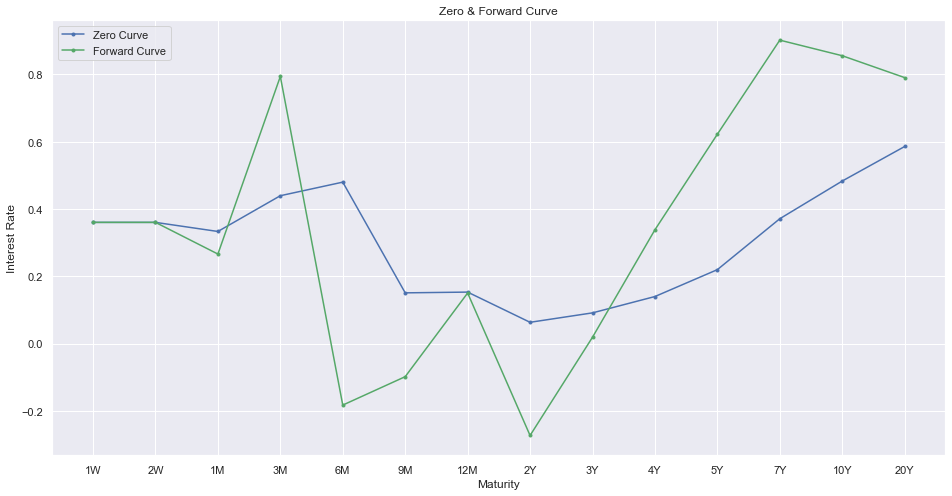

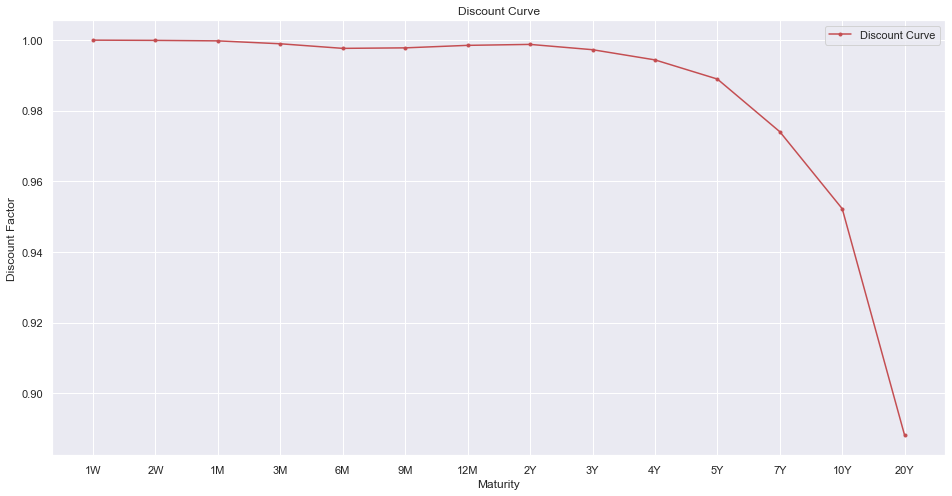

In [8]:
# 최종 확인(한국 커브만, 미국은 같음)
if __name__ == "__main__": # 메인함수 일 경우만 if문을 실행함
    
    # 오늘의 날짜
    todays_date = datetime.date(2020, 10, 9)

    # Get Quote & Build Swap Curve
    quote = GET_QUOTE(todays_date, 'KRW') # 데이터 불러오기
    curve = USDIRS_CURVE(todays_date, quote) # 커브 생성
    
    # quote 데이터프레임에 할인 계수, 제로 금리, 선도 금리 컬럼 생성
    quote['discount factor'] = np.nan
    quote['zero rate'] = np.nan
    quote['forward rate'] = np.nan
    
    # 인덱스별로 돌면서 할인 계수, 제로 금리, 선도 금리 값 계산 후 입력
    for tenor, date in zip(quote.index, quote['Maturity']):
        quote.loc[tenor, 'discount factor'] = DISCOUNT_FACTOR(date, curve)
        quote.loc[tenor, 'zero rate'] = ZERO_RATE(date, curve) * 100
        quote.loc[tenor, 'forward rate'] = FORWARD_RATE(date, curve) * 100
        
    # 입력 결과 출력
    print(quote[['discount factor', 'zero rate', 'forward rate']])
    
    # 플롯 그리기
    plt.figure(figsize=(16, 8))
    plt.plot(quote['zero rate'], 'b.-', label='Zero Curve')
    plt.plot(quote['forward rate'], 'g.-', label='Forward Curve')
    plt.title('Zero & Forward Curve', loc='center')
    plt.legend()
    plt.xlabel('Maturity')
    plt.ylabel('Interest Rate')
    
    plt.figure(figsize=(16, 8))
    plt.plot(quote['discount factor'], 'r.-', label='Discount Curve')
    plt.title('Discount Curve', loc='center')
    plt.legend()
    plt.xlabel('Maturity')
    plt.ylabel('Discount Factor')